<a href="https://colab.research.google.com/github/Xixianghu202124213/Capstone/blob/main/Inventory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import collections

In [2]:
def data_split(data, train_percentage = 0.8):
    total = pd.to_datetime(data["ds"].unique(),format="%d.%m.%Y")
    train = int(len(total) * train_percentage)
    train_idx = total[0:train]
    test_idx = total[train:train+90]
    train_dataset = data.iloc[[date in train_idx for date in data['ds']],:]
    test_dataset = data.iloc[[date in test_idx for date in data['ds']],:]
    return train_dataset, test_dataset

In [3]:
data=pd.read_csv("/content/drive/MyDrive/Data/historical_orders (1).csv",sep = ';')
data["DATE"]=pd.to_datetime(data["DATE"],format="%d.%m.%Y")
data = data.rename(columns={'DATE': 'ds', 'QUANTITY': 'y','MATERIAL_NUMBER' :'product', 'PLANT': 'plant'})
data = data[data['ds'] < '2020-01-01']

#splite the test and train
train, test = data_split(data)
train, test = data_split(data)
pivot_train = pd.pivot_table(train, values='y', index=['product', 'plant'], columns=['ds'], aggfunc=np.mean)
train_series = pivot_train.iloc[8,:]
pivot_test = pd.pivot_table(test, values='y', index=['product', 'plant'], columns=['ds'], aggfunc=np.mean)
test_series = pivot_test.iloc[8,:]


#Environment

In [4]:
class Inventory(gym.Env):
  interval=0
  forecast=[]
  def __init__(self,leading_time,demand_list,space,holding_cost=0.05,trans_con=20,trans_unit=0.02,revenue=5):
    global interval
    global forecast
    interval=leading_time
    forecast=demand_list
    self.inv=0
    self.holding_cost=holding_cost
    self.trans_con=trans_con
    self.trans_unit=trans_unit
    self.queue=[0]*interval
    self.plan=forecast
    self.action_space=space
    self.revenue=revenue
    
  def add(self,amount):
    self.inv=self.queue[0]
    self.queue=self.queue[1:]+[amount]

  def send(self,amount):
    if self.inv>amount:
      self.inv-=amount
      return False #have enough stock
    else:
      self.inv=0
      #print("the inventory is not enough")
      return True #bankrupt

  def reset(self):
    self.inv=0
    self.queue=[0]*interval
    self.plan=forecast
    return np.array([self.inv,sum(self.queue)])

  def step(self,action):
    new_state = None
    state = np.array([self.inv, sum(self.queue)])
    done = False
    reward=0
    if action not in self.action_space:
      done=True
      print("action is not allowed")
    else:
      if action!=0:
        reward=self.trans_con

      self.add(action)
      current=self.inv
      demand=self.plan[0]
      bankrupt=self.send(demand)
      self.plan=self.plan[1:]

      if len(self.plan)==1:
        done=True
      if bankrupt:
        reward+=self.trans_unit*action+self.holding_cost*self.inv+self.revenue*abs(demand-current)
      else:
        reward+=self.trans_unit*action+self.holding_cost*self.inv

    new_state=np.array([self.inv,sum(self.queue)])
    return state,-reward,new_state,done
    

#Benchmark & Goal

In [5]:
def Benchmark(env):
  goal_total_reward=0
  goal_done=False
  while not goal_done:
    minus=np.abs(np.asarray(space)-np.mean(env.plan)).tolist()
    id=minus.index(min(minus))
    goal_action=space[id]
 
    goal_state, goal_reward, goal_new_state,goal_done= env.step(goal_action)
    goal_total_reward+=goal_reward
  goal_state=env.reset()
  return goal_total_reward
def Goal(env):
  goal_reward=0
  done=False
  while not done:
    try:
      minus=np.abs(np.asarray(space)-env.plan[leading_time]).tolist()
      id=minus.index((min(minus)))
      action=space[id]
    except:
      action=0
    
    state, reward, new_state,done= env.step(action)
    goal_reward+=reward
  goal_state=env.reset()
  return goal_reward

#Dueling DQN

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []

    for i_episode in range(int(num_episodes)):
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        agent.update(transition_dict)

    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
 
    for i_episode in range(int(num_episodes)):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            if replay_buffer.size() > minimal_size:
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                agent.update(transition_dict)
        return_list.append(episode_return)

          
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [66]:
class VAnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()

        self.fc1=nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim)
        ) # 共享网络部分

        self.fc_A = nn.Sequential(
            nn.Linear(hidden_dim,64 ),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        ) 
        self.fc_V = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ) 

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
           # print("1111----11111")
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
           # print("2222-----22222")
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        #print(len(states))


        q_values = self.q_net(states).gather(1, actions)


        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1
    def save_pass_models(self,num):
        path='/content/drive/MyDrive/Model/Pass/pass_model('+str(num)+').pt'
        torch.save(self.q_net.state_dict(),path)


    def save_great_models(self,num):
        path='/content/drive/MyDrive/Model/Great/great_model('+str(num)+').pt'
        torch.save(self.q_net.state_dict(),path)
 
    
        



In [33]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,batch_size,bench_mark,goal):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    pass_list=[]
    great_list=[]
    x=0
    max=goal
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    #print(state,"----")
                    action_id = agent.take_action(state)
                    
                    action=space[action_id]
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    
                    _, reward, next_state,done = env.step(action)
                    replay_buffer.add(state, action_id, reward, next_state, done)
                    
                    state = next_state
                    episode_return += reward
                    
                    if replay_buffer.size() > minimal_size:
                        
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                    #print(state,"!!!!")
                return_list.append(episode_return)
                if episode_return>bench_mark:
                  #better than bench mark
                    pass_list.append(episode_return)

                if episode_return>max:
                    max=episode_return
                    x+=1
                    agent.save_great_models(x)
                    great_list.append(episode_return)

                
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'max_return':
                        '%.3f' % np.max(return_list[-i_episode:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list,pass_list,great_list

In [81]:
def test_DQN(agent, env, num_episodes,goal):
    return_list = []

    
    max=goal


    for i_episode in range(num_episodes):
        episode_return = 0
        state = env.reset()
        done = False
        action_list=[]
        inventory_list=[]
        while not done:
            #print(state,"----")
            action_id = agent.take_action(state)   
            action=space[action_id]
            action_list.append(action)
            
            _, reward, next_state,done = env.step(action)
            state = next_state
            episode_return += reward
            inventory_list.append(state[0])

        return_list.append(episode_return)
        if episode_return>max:
          optimal_policy=action_list
          optimal_inv=inventory_list
        if (i_episode + 1) % 10 == 0:
            print({
                'episode':
                '%d' % ( i_episode + 1),
                'return':
                '%.3f' % np.max(return_list[-10:])
            })
    return return_list,optimal_policy,optimal_inv

Iteration 9: 100%|██████████| 600/600 [06:50<00:00,  1.46it/s, episode=6000, max_return=-653201.500]


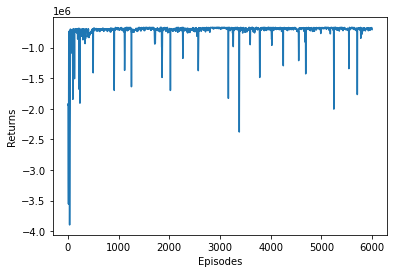

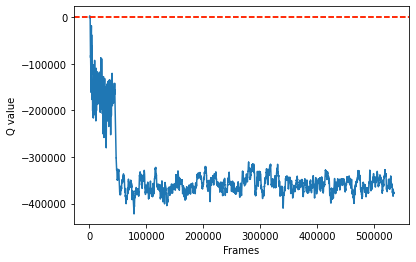

[-691562.0499999997,
 -690242.0499999997,
 -687359.5999999996,
 -681816.4499999996,
 -672840.2499999997,
 -657440.2499999997,
 -653240.2499999997,
 -652282.7499999997,
 -647290.2499999997]

In [67]:
leading_time=14
demand_list=test_series
space=[0,5000,10000,15000,20000,25000,30000,35000,40000]


lr = 1e-2
num_episodes = 6000
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 50
buffer_size = 50000
minimal_size = 1000
batch_size = 64

env=Inventory(leading_time,demand_list,space)
bench=Benchmark(env)
goal=Goal(env)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
state_dim = 2
action_dim = len(env.action_space)

random.seed(0)
np.random.seed(0)


torch.manual_seed(0)

replay_buffer =ReplayBuffer(buffer_size)

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list,pass_list,great_list = train_DQN(agent, env, num_episodes,replay_buffer, minimal_size,batch_size,bench,goal)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')

plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')

plt.show()

len(pass_list)
min(pass_list)
great_list

In [70]:
max(great_list)


-647290.2499999997

In [72]:
len(pass_list)

5919

In [71]:
np.mean(return_list)

-728766.096558333

In [68]:
g=list(filter(lambda x:x>-697098,return_list))

In [69]:
len(g)

3911

In [82]:
leading_time=14
demand_list=test_series
space=[0,5000,10000,15000,20000,25000,30000,35000,40000]
leading_time=14
demand_list=test_series
space=[0,5000,10000,15000,20000,25000,30000,35000,40000]


lr = 1e-2
num_episodes = 6000
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 50
buffer_size = 50000
minimal_size = 1000
batch_size = 64

env=Inventory(leading_time,demand_list,space)
bench=Benchmark(env)
goal=Goal(env)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
state_dim = 2
action_dim = len(env.action_space)

env=Inventory(leading_time,demand_list,space)
agent1 = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DuelingDQN')
agent1.q_net.load_state_dict(torch.load("/content/drive/MyDrive/Model/Great/great_model.pt"))
agent1.q_net.eval()

return_list,action_list,inv_list= test_DQN(agent1, env, 500,-697098)

{'episode': '10', 'return': '-690442.050'}
{'episode': '20', 'return': '-690862.050'}
{'episode': '30', 'return': '-691212.050'}
{'episode': '40', 'return': '-690512.050'}
{'episode': '50', 'return': '-667012.050'}
{'episode': '60', 'return': '-690862.050'}
{'episode': '70', 'return': '-691212.050'}
{'episode': '80', 'return': '-690862.050'}
{'episode': '90', 'return': '-689792.050'}
{'episode': '100', 'return': '-691212.050'}
{'episode': '110', 'return': '-691212.050'}
{'episode': '120', 'return': '-690862.050'}
{'episode': '130', 'return': '-691012.050'}
{'episode': '140', 'return': '-691112.050'}
{'episode': '150', 'return': '-689792.050'}
{'episode': '160', 'return': '-688144.750'}
{'episode': '170', 'return': '-690512.050'}
{'episode': '180', 'return': '-691212.050'}
{'episode': '190', 'return': '-690942.050'}
{'episode': '200', 'return': '-691212.050'}
{'episode': '210', 'return': '-691212.050'}
{'episode': '220', 'return': '-690162.050'}
{'episode': '230', 'return': '-691212.050

In [54]:
a=list(filter(lambda x:x>-697098,return_list))

In [55]:
len(a)

431

In [75]:
max(return_list)

-666312.0499999997

In [86]:
len(inv_list)

89

In [91]:
#fig=plt.subplots(fig)
#plt.plot(inv_list)
plt.plot(test_series[-89:])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9a7d2ee7a0> (for post_execute):


ValueError: ignored

ValueError: ignored